In [1]:
"""

Reasoning and Acting Agent

1. Learn how to create Tools in LangGraph
2. How to create a ReAct Graph
3. Work with different types of messages such as ToolMessages
4. Test out robustness of our Graph.

"""

'\n\nReasoning and Acting Agent\n\n1. Learn how to create Tools in LangGraph\n2. How to create a ReAct Graph\n3. Work with different types of messages such as ToolMessages\n4. Test out robustness of our Graph.\n \n'

In [ ]:
!pip install langchain_anthropic

In [3]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage # The foundational (parent) class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to the LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [4]:
# Annotated: provides additional context without affecting the type itself

email = Annotated[str, "This has to be a valid email format!"]
print(email.__metadata__)

# Sequence: to automatically handle the state updates for sequences such as by adding new messages to a chat history

('This has to be a valid email format!',)


In [5]:
# add_messages
# Reducer Function

# Rule that controls how updates from nodes are combined with the existing state.
# Tells us how to merge new data into the current state

# Without a reducer, updates would have replaced the existing value entirely!

# Without a reducer
state = {"messages": ["Hi!"]}
update = {"messages": ["Nice to meet you!"]}
new_state = {"messages": ["Nice to meet you!"]}

# With a reducer
state = {"messages": ["Hi!"]}
update = {"messages": ["Nice to meet you!"]}
new_state = {"messages": ["Hi!", "Nice to meet you!"]}

In [6]:
from getpass import getpass
import os

# Prompt for Claude API key (input is hidden)
claude_api_key = getpass("Enter your Claude API Key: ")
os.environ["ANTHROPIC_API_KEY"] = claude_api_key


Enter your Claude API Key: ··········


In [7]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [8]:
@tool
def add(a: int, b: int):
  """ Addition function that adds two numbers together"""
  return a + b

@tool
def subtract(a: int, b: int):
  """ Subtraction function that subtracts two numbers """
  return a - b

@tool
def multiply(a: int, b: int):
  """ Multiplication function that multiplies two numbers """
  return a * b

tools = [add, subtract, multiply]

In [9]:
model = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    anthropic_api_key=claude_api_key
).bind_tools(tools)

In [10]:
def model_call(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(
      content = "You are my AI Assistant, please answer my query to the best of your ability."
  )
  response = model.invoke([system_prompt] + state['messages'])
  return {"messages": [response]}

In [11]:
def should_continue(state: AgentState):
  messages = state['messages']
  last_message = messages[-1]
  if not last_message.tool_calls:

    return "end"

  else:
    return "continue"

In [12]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools = tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        # Edge: node
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")
app = graph.compile()

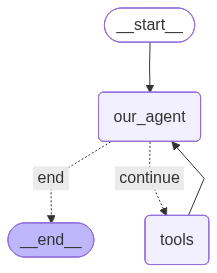

In [13]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
def print_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
      print(message)

    else:
      message.pretty_print()

In [15]:
inputs = {"messages": [("user", "Add 34+21. Add 3+4. Add 12 + 12")]}
print_stream(app.stream(inputs, stream_mode = "values"))

================================ Human Message =================================

Add 34+21. Add 3+4. Add 12 + 12
================================== Ai Message ==================================

[{'text': "I'll help you perform these three addition calculations.", 'type': 'text'}, {'id': 'toolu_01S52wHpPzoX1Buwwyhbxbof', 'input': {'a': 34, 'b': 21}, 'name': 'add', 'type': 'tool_use'}, {'id': 'toolu_01Dj91ACsVZmhtK6VrfHozfA', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}, {'id': 'toolu_01H2PPNixepBUKr82tZqmVMc', 'input': {'a': 12, 'b': 12}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01S52wHpPzoX1Buwwyhbxbof)
 Call ID: toolu_01S52wHpPzoX1Buwwyhbxbof
  Args:
    a: 34
    b: 21
  add (toolu_01Dj91ACsVZmhtK6VrfHozfA)
 Call ID: toolu_01Dj91ACsVZmhtK6VrfHozfA
  Args:
    a: 3
    b: 4
  add (toolu_01H2PPNixepBUKr82tZqmVMc)
 Call ID: toolu_01H2PPNixepBUKr82tZqmVMc
  Args:
    a: 12
    b: 12
================================= Tool Message ====================

In [16]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please")]}
print_stream(app.stream(inputs, stream_mode = "values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation and tell you a joke!", 'type': 'text'}, {'id': 'toolu_01A7ciySdwc44vK6XBPvkjKU', 'input': {'a': 40, 'b': 12}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01A7ciySdwc44vK6XBPvkjKU)
 Call ID: toolu_01A7ciySdwc44vK6XBPvkjKU
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================

[{'id': 'toolu_01FtVoFNQ8qesEFMy92VQmZT', 'input': {'a': 52, 'b': 6}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01FtVoFNQ8qesEFMy92VQmZT)
 Call ID: toolu_01FtVoFNQ8qesEFMy92VQmZT
  Args:
    a: 52
    b: 6
================================= Too